In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np
import os
import glob
import imageio.v2 as imageio
import PIL
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
from tensorflow.keras import datasets, models
from tensorflow.keras.optimizers import Adam

In [2]:
# Load and prepare the dataset
# dataset_path = 'F:/UK/UAL_CCI/31CodingThree/shoes/shoeTypeClassifierDataset/training/sneakers'  # Path to the dataset
dataset_path = 'G:/Dataset/fastfood/FastFoodClassification/Train/Donut'

# Get a list of image files in the dataset directory
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.jpeg')]
image_size = (56, 56)  # Desired size for the images


resized_images = []

# Load each image using PIL, resize it, and append it to the image list
for file in image_files:
    image = Image.open(file)
    image = image.resize(image_size)
    image_array = np.array(image).astype('float32')
    resized_images.append(image_array)

# Convert the list of resized images to a NumPy array
resized_images = np.array(resized_images)

# Normalize the images to [-1, 1]
resized_images = (resized_images - 127.5) / 127.5


# Convert the NumPy array to a list of tensors
image_tensors = [tf.convert_to_tensor(image) for image in resized_images]

BUFFER_SIZE = len(image_tensors)
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(image_tensors).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Print the info of the train_dataset
print(resized_images.shape)

print(resized_images[0].dtype)

dataset_length = train_dataset.cardinality().numpy()
print(dataset_length)


(1428, 56, 56, 3)
float32
6


In [3]:
# Create the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 3)  # Update output shape

    return model


In [4]:
# Create the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[56, 56, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [5]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
# Create the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

In [7]:
# Define the optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
# Define the checkpoint directory and prefix for saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:
# Define the training loop
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 36

# Random seed for generating images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
# Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [11]:
# Define the training function
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in train_dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # Save the model checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate and save the final images
    generate_and_save_images(generator, epochs, seed)

In [12]:
# Define the function to generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
      plt.subplot(6, 6, i+1)
      img_arr = predictions[i].numpy()
      plt.imshow((img_arr[:, :, :] * 127.5 + 127.5).astype(np.uint8))
      plt.axis('off')
  
  if (epoch % 10 == 0):
      plt.savefig('predict_image_epoch_{:04d}.png'.format(epoch))
      plt.show()
      plt.close(fig)

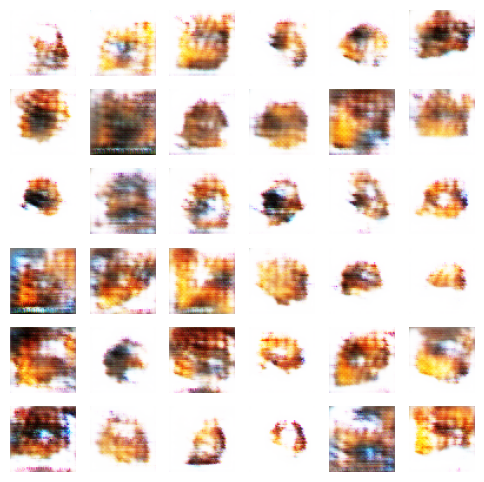

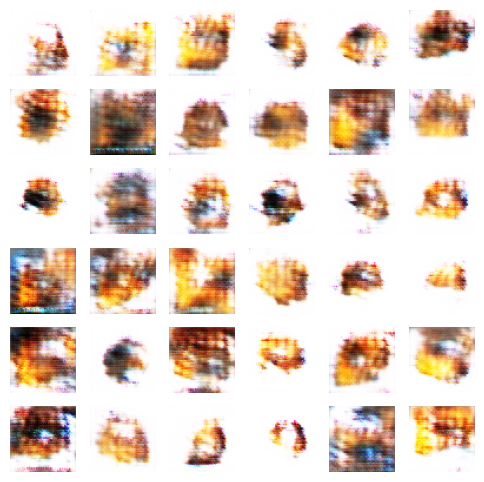

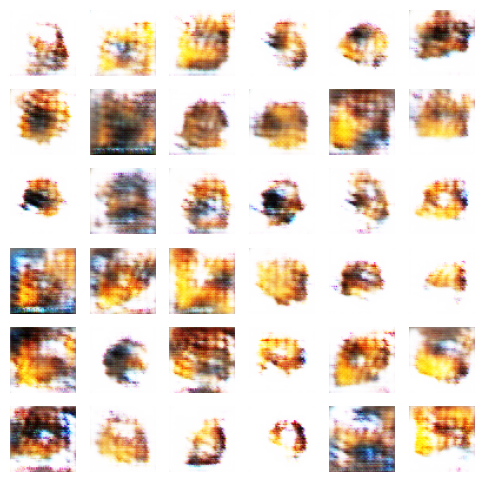

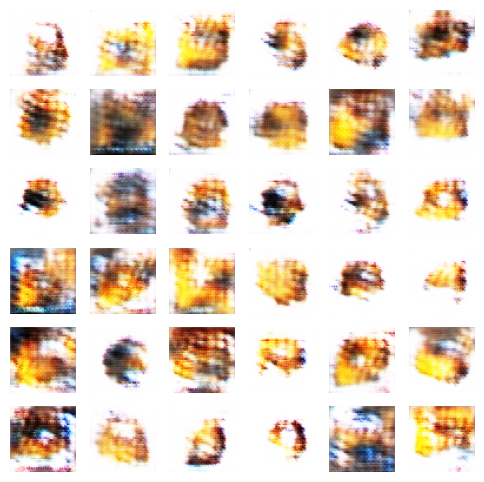

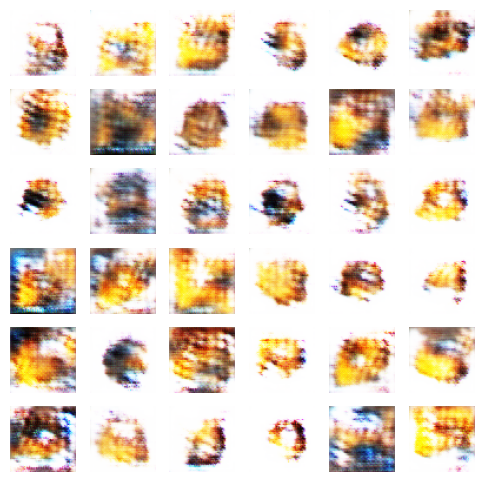

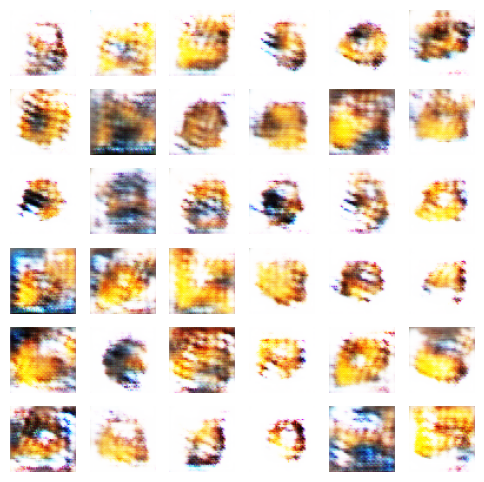

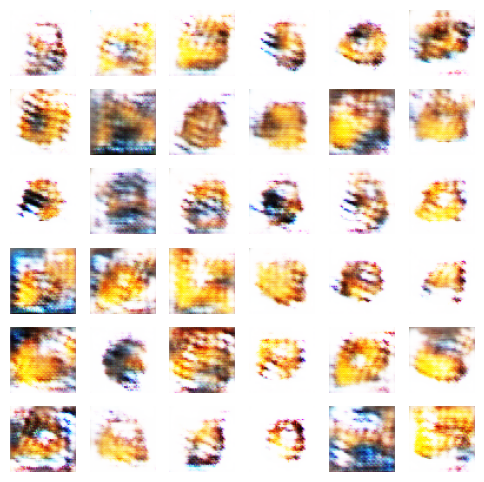

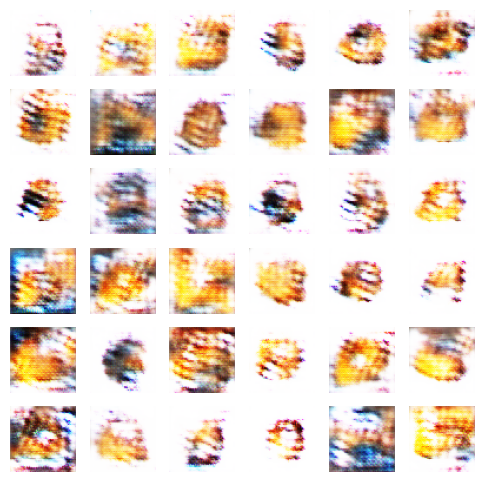

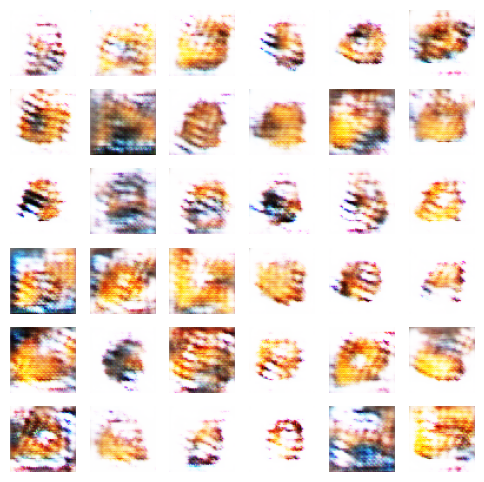

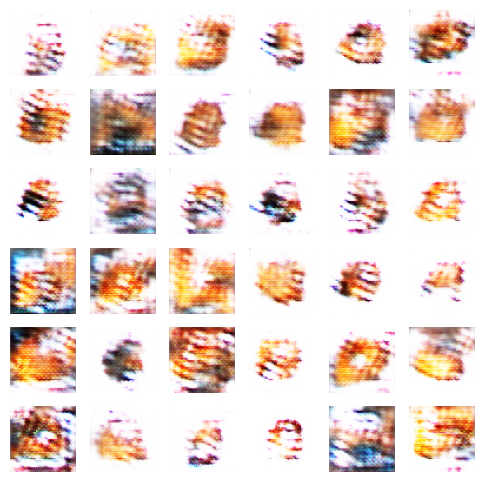

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 227: invalid start byte

In [13]:
# Train the model
train(train_dataset, EPOCHS)

In [14]:

# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [17]:
# Create an animated GIF of the generated images
anim_file = 'dcgan_predict.gif'

# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('food_image_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

# Get a list of image files
filenames = sorted(glob.glob('food_image_epoch_*.png'))
# Read the images and append them in reverse order for smoother looping
images = []
for filename in filenames:
    image = PIL.Image.open(filename)
    images.append(image)
images.extend(reversed(images))

# Save the images as an animated GIF
images[0].save(anim_file,
               save_all=True,
               append_images=images[1:],
               duration=300,
               loop=0)


FileNotFoundError: [Errno 2] No such file or directory: 'food_image_epoch_5000.png'

In [18]:
# Embed the GIF in the notebook
import IPython.display as display
display.Image(filename=anim_file)

FileNotFoundError: [Errno 2] No such file or directory: 'dcgan_predict.gif'